In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import os
import json

import bokeh
import geopandas

pd.options.display.max_colwidth=200
%matplotlib inline

In [2]:
# data directory
data_dir = "../data"
raw_data = os.path.join(data_dir, "raw")

In [3]:
df = pd.read_csv(os.path.join(raw_data, "summary_listings.csv"))


In [5]:
listings = pd.read_csv(os.path.join(raw_data, "detailed_listings.csv"), low_memory=False)

In [7]:
listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 106 columns):
id                                              int64
listing_url                                     object
scrape_id                                       int64
last_scraped                                    object
name                                            object
summary                                         object
space                                           object
description                                     object
experiences_offered                             object
neighborhood_overview                           object
notes                                           object
transit                                         object
access                                          object
interaction                                     object
house_rules                                     object
thumbnail_url                                   float64
medium_url 

In [8]:
cols_of_interest = ['id', 'listing_url']
df_listings = listings[cols_of_interest]

In [9]:
df_listings.head()

,id,listing_url
0,2595,https://www.airbnb.com/rooms/2595
1,3647,https://www.airbnb.com/rooms/3647
2,3831,https://www.airbnb.com/rooms/3831
3,5022,https://www.airbnb.com/rooms/5022
4,5099,https://www.airbnb.com/rooms/5099


In [11]:
df_listings[df_listings.id == 28711]

,id,listing_url


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 16 columns):
id                                48864 non-null int64
name                              48848 non-null object
host_id                           48864 non-null int64
host_name                         48846 non-null object
neighbourhood_group               48864 non-null object
neighbourhood                     48864 non-null object
latitude                          48864 non-null float64
longitude                         48864 non-null float64
room_type                         48864 non-null object
price                             48864 non-null int64
minimum_nights                    48864 non-null int64
number_of_reviews                 48864 non-null int64
last_review                       38733 non-null object
reviews_per_month                 38733 non-null float64
calculated_host_listings_count    48864 non-null int64
availability_365                  48864 non-null int64

## Subset the dataset based on neighbourhood_group and room_type

In [7]:
df.neighbourhood_group.value_counts()

Manhattan        21456
Brooklyn         20114
Queens            5811
Bronx             1105
Staten Island      378
Name: neighbourhood_group, dtype: int64

In [8]:
df.room_type.value_counts()

Entire home/apt    25296
Private room       22397
Shared room         1171
Name: room_type, dtype: int64

In [14]:
df.groupby(['neighbourhood_group', 'room_type'])['price'].count()

neighbourhood_group  room_type      
Bronx                Entire home/apt      378
                     Private room         659
                     Shared room           68
Brooklyn             Entire home/apt     9565
                     Private room       10131
                     Shared room          418
Manhattan            Entire home/apt    13054
                     Private room        7931
                     Shared room          471
Queens               Entire home/apt     2118
                     Private room        3489
                     Shared room          204
Staten Island        Entire home/apt      181
                     Private room         187
                     Shared room           10
Name: price, dtype: int64

In [23]:
df = df[(df.neighbourhood_group == 'Manhattan') & (df.room_type == 'Entire home/apt')]
df.shape

(13054, 16)

## Construct a geopandas dataframe

In [24]:
geo_df = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [25]:
# filter 
cols = ['price', 'neighbourhood', 'neighbourhood_group', 'geometry']
price_df = geo_df[cols]

In [26]:
price_grouped = price_df.groupby('neighbourhood')[['price']].mean()
mean_price_df = pd.merge(price_df, price_grouped, left_on='neighbourhood', right_index=True)
mean_price_df.rename({'price_x': 'price', 'price_y': 'mean_neibhourhood_price'}, axis=1, inplace=True)

mean_price_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price
0,225,Midtown,Manhattan,POINT (-73.98376999999999 40.75362),281.951103
229,250,Midtown,Manhattan,POINT (-73.96991 40.7589),281.951103
241,110,Midtown,Manhattan,POINT (-73.96897 40.75749),281.951103
372,139,Midtown,Manhattan,POINT (-73.98876 40.74503),281.951103
380,145,Midtown,Manhattan,POINT (-73.96699 40.75579),281.951103


In [28]:
mean_price_df.neighbourhood.value_counts()

Upper East Side        1287
Upper West Side        1226
Hell's Kitchen         1170
East Village           1169
Midtown                1043
Harlem                 1030
Chelsea                 819
West Village            651
Financial District      579
Lower East Side         496
East Harlem             483
Murray Hill             403
Kips Bay                331
Washington Heights      302
Greenwich Village       289
Gramercy                252
SoHo                    234
Chinatown               206
Nolita                  173
Theater District        160
Morningside Heights     146
Tribeca                 142
Inwood                  102
Little Italy             77
NoHo                     68
Flatiron District        67
Battery Park City        53
Civic Center             32
Two Bridges              26
Roosevelt Island         19
Stuyvesant Town          14
Marble Hill               5
Name: neighbourhood, dtype: int64

<Figure size 432x288 with 0 Axes>

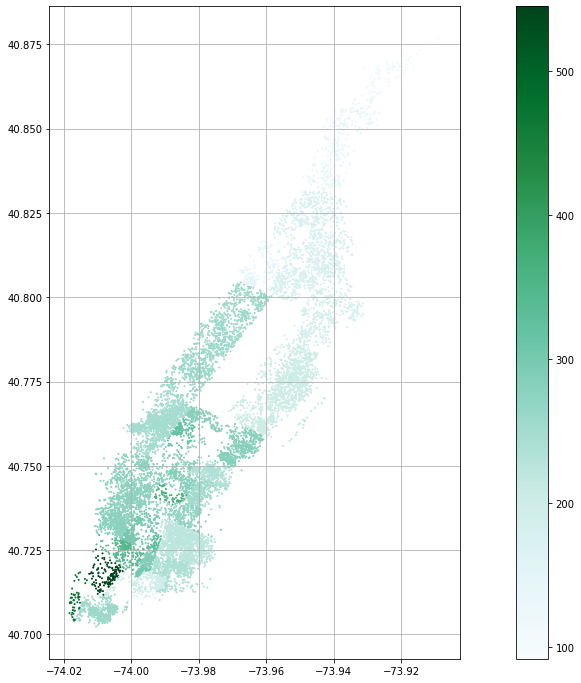

In [29]:
plt.figure()
mean_price_df.plot(figsize=(20, 12),
                  column='mean_neibhourhood_price',
                  markersize=1,
                  cmap='BuGn',
                  legend=True)
plt.grid()
plt.show()

## Get the neighbourhood polygons

In [30]:
nbhoods = geopandas.read_file('../data/raw/neighbourhoods.geojson')

In [118]:
nbhoods.crs

{'init': 'epsg:4326'}

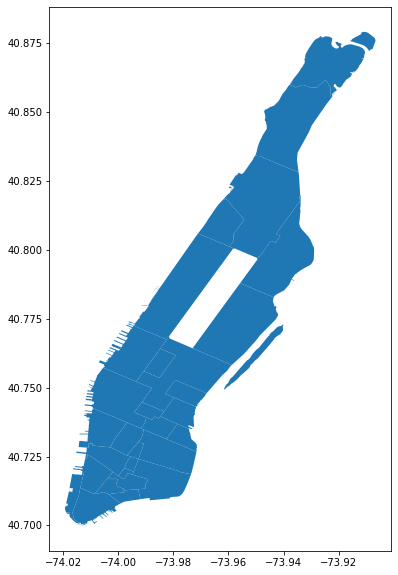

In [124]:
nbhoods.plot(figsize=(20,10))
plt.show()

In [121]:
nbhoods1 = nbhoods.copy()

In [122]:
nbhoods1.to_crs(epsg=2831, inplace=True)

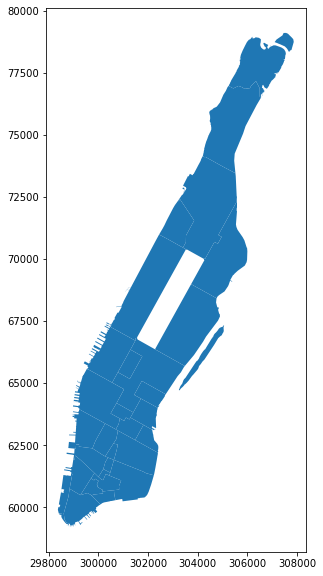

In [125]:
nbhoods1.plot(figsize=(20,10))
plt.show()

In [129]:
nbhoods.head()

,neighbourhood,neighbourhood_group,geometry
18,Battery Park City,Manhattan,"(POLYGON ((-74.01375400000001 40.71369, -74.014262 40.710928, -74.016542 40.704733, -74.01617400000001 40.702572, -74.01563 40.701862, -74.01512700000001 40.70139, -74.014008 40.701043, -74.013959..."
43,Chinatown,Manhattan,"(POLYGON ((-73.99999099999999 40.717977, -73.998636 40.717077, -73.99779100000001 40.716793, -73.996478 40.719048, -73.99480800000001 40.718457, -73.989155 40.716708, -73.9902 40.714665, -73.99012..."
52,Chelsea,Manhattan,"(POLYGON ((-73.993464 40.75219, -73.987937 40.749855, -73.987933 40.749853, -73.987973 40.749467, -73.991356 40.744763, -73.99421100000001 40.741013, -73.989777 40.739169, -73.990371 40.737098, -7..."
53,Civic Center,Manhattan,"(POLYGON ((-73.99799400000001 40.712722, -73.99777 40.711971, -74.002363 40.711591, -74.003337 40.711236, -74.003355 40.71123, -74.00366200000001 40.711487, -74.005358 40.712151, -74.005769 40.712..."
80,East Harlem,Manhattan,"(POLYGON ((-73.93383 40.819521, -73.93383 40.819521, -73.933829 40.815585, -73.93394499999999 40.815588, -73.93394499999999 40.815588, -73.93394600000001 40.815588, -73.934015 40.814484, -73.93385..."


In [126]:
nbhoods1.head()

,neighbourhood,neighbourhood_group,geometry
18,Battery Park City,Manhattan,"(POLYGON ((298837.8143698205 60744.72446247662, 298794.8394438099 60438.01646611918, 298602.0460876819 59750.10775074532, 298633.1012245106 59510.12726494684, 298679.0617406053 59431.27486981096, ..."
43,Chinatown,Manhattan,"(POLYGON ((300000.7604331822 61220.69666938045, 300115.2494295053 61120.75420329324, 300186.6474153663 61089.2179783619, 300297.5780696684 61339.63526971768, 300438.6822934716 61274.01280200375, 3..."
52,Chelsea,Manhattan,"(POLYGON ((300551.9599924205 65020.01784118942, 301018.7464444718 64760.76868638342, 301019.0842837177 64760.54663555741, 301015.7120823966 64717.68138256792, 300730.0602986221 64195.27489482101, ..."
53,Civic Center,Manhattan,"(POLYGON ((300169.5054704888 60637.14058565246, 300188.435422769 60553.74391642209, 299800.3249136892 60511.54593429546, 299718.0197580891 60472.12653964652, 299716.4987123871 60471.46030921204, 2..."
80,East Harlem,Manhattan,"(POLYGON ((305582.3551635673 72499.16477866231, 305582.3551635673 72499.16477866231, 305582.7697070272 72062.07281846402, 305572.9826736354 72062.3985813029, 305572.9826736354 72062.3985813029, 30..."


In [127]:
nbhoods1.neighbourhood_group.value_counts()

Manhattan    32
Name: neighbourhood_group, dtype: int64

In [33]:
nbhoods.neighbourhood_group.value_counts()

Queens           55
Bronx            50
Staten Island    48
Brooklyn         48
Manhattan        32
Name: neighbourhood_group, dtype: int64

In [35]:
nbhoods = nbhoods[nbhoods.neighbourhood_group == 'Manhattan']

In [128]:
nbhoods.head()

,neighbourhood,neighbourhood_group,geometry
18,Battery Park City,Manhattan,"(POLYGON ((-74.01375400000001 40.71369, -74.014262 40.710928, -74.016542 40.704733, -74.01617400000001 40.702572, -74.01563 40.701862, -74.01512700000001 40.70139, -74.014008 40.701043, -74.013959..."
43,Chinatown,Manhattan,"(POLYGON ((-73.99999099999999 40.717977, -73.998636 40.717077, -73.99779100000001 40.716793, -73.996478 40.719048, -73.99480800000001 40.718457, -73.989155 40.716708, -73.9902 40.714665, -73.99012..."
52,Chelsea,Manhattan,"(POLYGON ((-73.993464 40.75219, -73.987937 40.749855, -73.987933 40.749853, -73.987973 40.749467, -73.991356 40.744763, -73.99421100000001 40.741013, -73.989777 40.739169, -73.990371 40.737098, -7..."
53,Civic Center,Manhattan,"(POLYGON ((-73.99799400000001 40.712722, -73.99777 40.711971, -74.002363 40.711591, -74.003337 40.711236, -74.003355 40.71123, -74.00366200000001 40.711487, -74.005358 40.712151, -74.005769 40.712..."
80,East Harlem,Manhattan,"(POLYGON ((-73.93383 40.819521, -73.93383 40.819521, -73.933829 40.815585, -73.93394499999999 40.815588, -73.93394499999999 40.815588, -73.93394600000001 40.815588, -73.934015 40.814484, -73.93385..."


In [130]:
nbhoods1.shape

(32, 3)

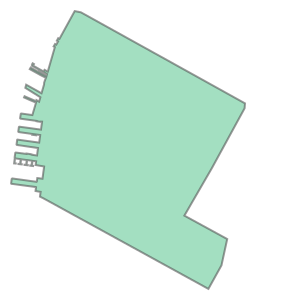

In [132]:
list(nbhoods1[nbhoods1.neighbourhood == 'Chelsea'].geometry)[0]

In [133]:
chelsea = list(nbhoods1[nbhoods1.neighbourhood == 'Chelsea'].geometry)[0]

## Get subway data

In [134]:
subway = geopandas.read_file('../data/raw/subway.geojson')

In [135]:
subway.crs

{'init': 'epsg:4326'}

In [137]:
subway.to_crs(nbhoods1.crs, inplace=True)

In [138]:
subway.head()

,name,url,line,objectid,notes,geometry
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (300754.3820963873 62561.8652154074)
1,Canal St,http://web.mta.info/nyct/service/,4-6-6 Express,2,"4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound",POINT (299983.6931963867 61312.42261541016)
2,50th St,http://web.mta.info/nyct/service/,1-2,3,"1-all times, 2-nights",POINT (301363.7437963872 66079.30631540947)
3,Bergen St,http://web.mta.info/nyct/service/,2-3-4,4,"4-nights, 3-all other times, 2-all times",POINT (302113.562396386 57099.46991541053)
4,Pennsylvania Ave,http://web.mta.info/nyct/service/,3-4,5,"4-nights, 3-all other times",POINT (308888.455396388 55311.34031541083)


In [139]:
subway.shape

(473, 6)

In [140]:
subway[subway.geometry.within(chelsea)]

,name,url,line,objectid,notes,geometry
95,23rd St,http://web.mta.info/nyct/service/,1-2,96,"1-all times, 2-nights",POINT (300366.8073963855 64119.5128154069)
198,28th St,http://web.mta.info/nyct/service/,1-2,199,"1-all times, 2-nights",POINT (300560.362196385 64467.55121541115)
202,18th St,http://web.mta.info/nyct/service/,1-2,203,"1-all times, 2-nights",POINT (300179.8223963852 63781.80721541057)
357,34th St - Penn Station,http://web.mta.info/nyct/service/,1-2-3,358,"1,2,3-all times",POINT (300755.2498963833 64818.26031541228)
364,23rd St,http://web.mta.info/nyct/service/,F-M,365,"F-all times, M-weekdays and evenings",POINT (300611.0742963859 63994.41251541291)
435,23rd St,http://web.mta.info/nyct/service/,A-C-E,436,"A-nights, C-all other times, E-all times",POINT (300165.4514963879 64322.16921541272)
440,14th St,http://web.mta.info/nyct/service/,F-M,441,"F-all times, M-weekdays and evenings",POINT (300320.2140963881 63469.54351541014)
443,14th St,http://web.mta.info/nyct/service/,A-C-E,444,"A,E-all times, C-all times exc nights",POINT (299857.2566963873 63765.48231540788)
469,34th St - Hudson Yards,http://web.mta.info/nyct/service/,7-7 Express,470,"7-all times, 7 Express-rush hours AM westbound, PM eastbound",POINT (299814.4661963859 65381.61421541152)


In [141]:
subway_chelsea = subway[subway.geometry.within(chelsea)]

In [142]:
subway_chelsea.name.str.contains("Penn")

95     False
198    False
202    False
357     True
364    False
435    False
440    False
443    False
469    False
Name: name, dtype: bool

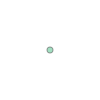

In [143]:
list(subway_chelsea[subway_chelsea.name.str.contains("Penn")].geometry)[0]

In [144]:
penn_station_nyc = list(subway_chelsea[subway_chelsea.name.str.contains("Penn")].geometry)[0]

In [145]:
type(subway.geometry)

geopandas.geoseries.GeoSeries

## Now get all airbnb's in Chelsea

In [146]:
#chelsea_airbnb
mean_price_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13054 entries, 0 to 27439
Data columns (total 5 columns):
price                      13054 non-null int64
neighbourhood              13054 non-null object
neighbourhood_group        13054 non-null object
geometry                   13054 non-null object
mean_neibhourhood_price    13054 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 611.9+ KB


In [147]:
type(mean_price_df)

geopandas.geodataframe.GeoDataFrame

In [151]:
mean_price_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price
0,225,Midtown,Manhattan,POINT (-73.98376999999999 40.75362),281.951103
229,250,Midtown,Manhattan,POINT (-73.96991 40.7589),281.951103
241,110,Midtown,Manhattan,POINT (-73.96897 40.75749),281.951103
372,139,Midtown,Manhattan,POINT (-73.98876 40.74503),281.951103
380,145,Midtown,Manhattan,POINT (-73.96699 40.75579),281.951103


In [152]:
mean_price_df.crs = {'init': 'epsg:4326'}

In [153]:
mean_price_df.to_crs(nbhoods1.crs, inplace=True)

In [154]:
mean_price_df.shape

(13054, 5)

In [155]:
chelsea_airbnb_df = mean_price_df[mean_price_df.neighbourhood == "Chelsea"]

In [156]:
chelsea_airbnb_df.shape

(819, 5)

In [157]:
# check the CRS
print(chelsea_airbnb_df.crs)

{'init': 'epsg:2831', 'no_defs': True}


In [158]:
chelsea_airbnb_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price
60,375,Chelsea,Manhattan,POINT (300396.94676678 64358.15783347707),277.509158
187,125,Chelsea,Manhattan,POINT (300000.8446426383 63700.73962238332),277.509158
249,205,Chelsea,Manhattan,POINT (300365.7188995124 63930.61914826695),277.509158
353,130,Chelsea,Manhattan,POINT (300385.1072123948 64657.98854326614),277.509158
359,279,Chelsea,Manhattan,POINT (299896.1076924781 63610.79104894029),277.509158


In [62]:
chelsea_airbnb_df.geometry.within(chelsea).sum()

818

In [171]:
chelsea_airbnb_df.distance(penn_station_nyc).shape

(819,)

In [172]:
chelsea_airbnb_df.shape

(819, 6)

In [164]:
chelsea_airbnb_df['distance'] = chelsea_airbnb_df.distance(penn_station_nyc)

/Users/Shravan/anaconda3/envs/geo_pandas/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [165]:
chelsea_airbnb_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price,distance
60,375,Chelsea,Manhattan,POINT (300396.94676678 64358.15783347707),277.509158,583.159864
187,125,Chelsea,Manhattan,POINT (300000.8446426383 63700.73962238332),277.509158,1348.324807
249,205,Chelsea,Manhattan,POINT (300365.7188995124 63930.61914826695),277.509158,969.350937
353,130,Chelsea,Manhattan,POINT (300385.1072123948 64657.98854326614),277.509158,403.351766
359,279,Chelsea,Manhattan,POINT (299896.1076924781 63610.79104894029),277.509158,1481.926906


In [173]:
import seaborn as sns

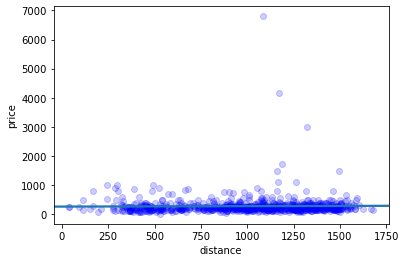

In [174]:
sns.regplot('distance', 'price', ci=False, data=chelsea_airbnb_df, scatter_kws={'alpha':0.2, 'color':'blue'})

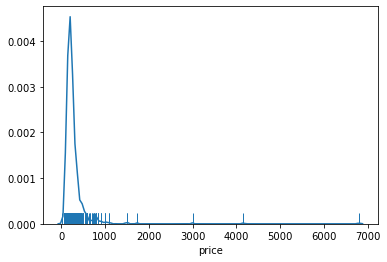

In [176]:
sns.distplot(chelsea_airbnb_df['price'], hist=False, rug=True)

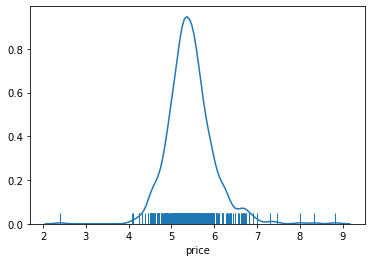

In [178]:
sns.distplot(np.log(chelsea_airbnb_df['price']), hist=False, rug=True)

In [179]:
chelsea_airbnb_df['log_price'] = np.log(chelsea_airbnb_df.price)

/Users/Shravan/anaconda3/envs/geo_pandas/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [180]:
chelsea_airbnb_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price,distance,log_price
60,375,Chelsea,Manhattan,POINT (300396.94676678 64358.15783347707),277.509158,583.159864,5.926926
187,125,Chelsea,Manhattan,POINT (300000.8446426383 63700.73962238332),277.509158,1348.324807,4.828314
249,205,Chelsea,Manhattan,POINT (300365.7188995124 63930.61914826695),277.509158,969.350937,5.323010
353,130,Chelsea,Manhattan,POINT (300385.1072123948 64657.98854326614),277.509158,403.351766,4.867534
359,279,Chelsea,Manhattan,POINT (299896.1076924781 63610.79104894029),277.509158,1481.926906,5.631212


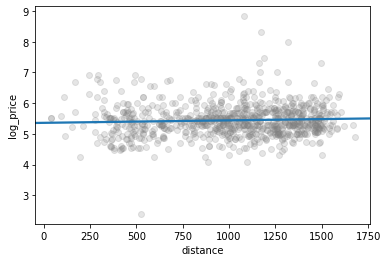

In [184]:
sns.regplot('distance', 'log_price', ci=False, data=chelsea_airbnb_df, scatter_kws={'alpha':0.2, 'color':'gray'})

In [185]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [187]:
normalize(chelsea_airbnb_df.log_price)

60       0.549113
187      0.378170
249      0.455144
353      0.384273
359      0.503100
           ...   
48658    0.546603
48816    0.511249
48835    0.434908
48838    0.434908
48851    0.477056
Name: log_price, Length: 819, dtype: float64

In [188]:
chelsea_airbnb_df['normalize_log_price'] = normalize(chelsea_airbnb_df.log_price)

/Users/Shravan/anaconda3/envs/geo_pandas/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [189]:
chelsea_airbnb_df.head()

,price,neighbourhood,neighbourhood_group,geometry,mean_neibhourhood_price,distance,log_price,normalize_log_price
60,375,Chelsea,Manhattan,POINT (300396.94676678 64358.15783347707),277.509158,583.159864,5.926926,0.549113
187,125,Chelsea,Manhattan,POINT (300000.8446426383 63700.73962238332),277.509158,1348.324807,4.828314,0.378170
249,205,Chelsea,Manhattan,POINT (300365.7188995124 63930.61914826695),277.509158,969.350937,5.323010,0.455144
353,130,Chelsea,Manhattan,POINT (300385.1072123948 64657.98854326614),277.509158,403.351766,4.867534,0.384273
359,279,Chelsea,Manhattan,POINT (299896.1076924781 63610.79104894029),277.509158,1481.926906,5.631212,0.503100


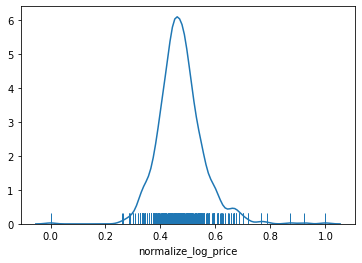

In [190]:
sns.distplot(chelsea_airbnb_df['normalize_log_price'], hist=False, rug=True)

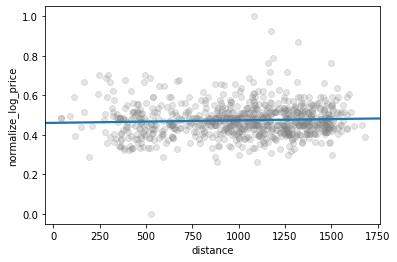

In [196]:
sns.regplot('distance', 'normalize_log_price', ci=False,
            data=chelsea_airbnb_df, scatter_kws={'alpha':0.2, 'color':'gray'})

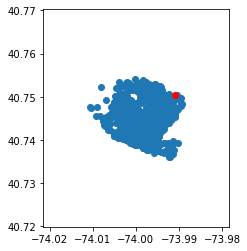

In [90]:
ax = chelsea_airbnb_df.plot()
geopandas.GeoSeries([penn_station_nyc]).plot(ax=ax, color='red')
plt.show()

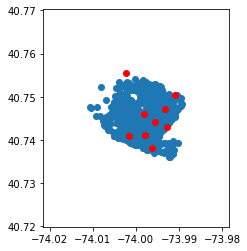

In [99]:
ax = chelsea_airbnb_df.plot()
subway_chelsea.plot(ax=ax, color='red')
plt.show()

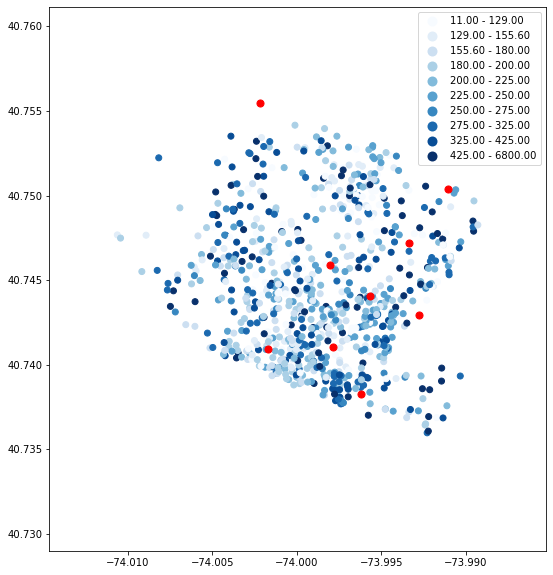

In [115]:
ax = chelsea_airbnb_df.plot(figsize=(20,10), column='price', scheme='quantiles',  k=10, cmap='Blues', legend=True)
subway_chelsea.plot(ax=ax, color='red', markersize=50)
plt.show()